In [3]:
from Genome.goldstandard_pair.lls import *
# read net
gd = '/home/hermuba/data0118/goldstandard/tf_intersectGO.smpl'
net = '/home/hermuba/data0118/network1122/combined_baye'
gold = read_gold(gd)
all_chunks = read_net_by_chunk(net)
all_chunk = merge_net_with_all_chunks(gold,all_chunks)
all_chunk.shape

(3753, 4)

In [5]:
all_chunk.head()

,combined_lls,gene_one,gene_two,goldstandard
0,7.262910,562.23301.con.0004_15|562.23301,JAPE01000016_88|1400157.3,0
1,6.573675,562.23864.con.0080_17|562.23864,562.23286.con.0020_1|562.23286,0
2,4.202705,FLWH01000003_385|562.12962,FLWH01000011_78|562.12962,1
3,4.836801,FLWH01000006_253|562.12962,562.23366.con.0009_153|562.23366,0
4,3.734024,JAPE01000010_366|1400157.3,562.22863.con.0020_19|562.22863,0


In [21]:
# don't need to calculate LLS cause it's done.We need to change LLS threshold and calculate PPV and coverage
def PPV_coverage(lls_thres, all_df):
    '''
    calculate PPV, coverage using different threshold of LLS cutoff
    input: lls_thres: the LLS cutoff to consider interaction as True
    all_df: dataframe containing goldstandard and lls
    '''
    all_df['ans'] = all_df['combined_lls'].map(lambda x: True if x > lls_thres else False)

    # calculate coverage
    total_nodes = set(all_df['gene_one']).union(set(all_df['gene_two']))
    net = all_df.loc[all_df['ans'] == True]
    
   
    covered_nodes = set(net['gene_one']).union(set(net['gene_two']))
    coverage = len(covered_nodes)/len(total_nodes)

    # calculate PPV
    grouped = all_df.groupby(by = ['goldstandard', 'ans']).count()['gene_one']

    try:
        tp = grouped[1, True]
        fp = grouped[0, True]
        PPV = tp/(tp+fp)
    except KeyError:
        PPV = 0
        
    return(coverage, PPV)

def try_diff_lls_thres(all_df):
    '''
    try different LLS threshold to see the tradeoffs between coverage and PPV
    LLS threshold as df['lls'].unique values
    all_df: dataframe containing goldstandard and lls
    '''
    tradeoff = pd.DataFrame(columns = ['thres', 'coverage', 'PPV'])

    try_list = np.sort(all_df['combined_lls'].unique())[5:-1]
    
    for t in try_list:
        
        cov, PPV = PPV_coverage(t, all_df)
        tradeoff.loc[t] = [t, cov, PPV]
    return(tradeoff)


In [23]:
tradeoff = try_diff_lls_thres(all_chunk)

In [24]:
tradeoff.to_csv('~/data0118/PPV_coverage/combined')

Text(0, 0.5, 'PPV')

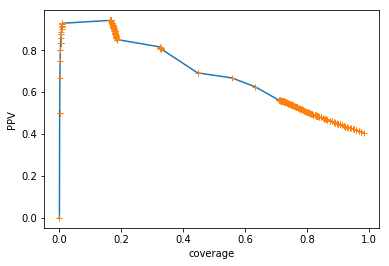

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '-')
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '+')
plt.xlabel('coverage')
plt.ylabel('PPV')

Text(0, 0.5, 'PPV')

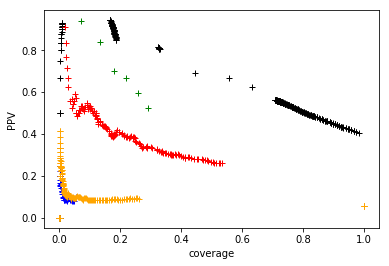

In [29]:
# plot together!!
domain_tradeoff = pd.read_csv('~/data0118/PPV_coverage/domain_250', header = 0)
eskape_tradeoff = pd.read_csv('~/data0118/PPV_coverage/eskape_300_nrm_mutual', header = 0)
refseq_tradeoff = pd.read_csv('~/data0118/PPV_coverage/refseq_300_nrm_mutual', header = 0)
string_tradeoff = pd.read_csv('~/data0118/PPV_coverage/string_300', header = 0)
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '+', color = 'black')
plt.plot(domain_tradeoff['coverage'], domain_tradeoff['PPV'], '+', color = 'green')
plt.plot(eskape_tradeoff['coverage'], eskape_tradeoff['PPV'], '+', color = 'blue')
plt.plot(refseq_tradeoff['coverage'], refseq_tradeoff['PPV'], '+', color = 'orange')
plt.plot(string_tradeoff['coverage'], string_tradeoff['PPV'], '+', color = 'red')
plt.xlabel('coverage')
plt.ylabel('PPV')